###  Trabajo proyecto final IIQ2003

## Transporte de contaminantes en piscinas mineras

#### Ecuación de Richards

La ecuación de acumulación volumetrica esta dada por:

$$ \frac{\partial \theta}{\partial t} = 
\frac{\partial}{\partial z} 
\left[
K \left( \frac{\partial h}{\partial z} + 1 \right)
\right] $$

Donde $\theta$ es el contenido volumétrico de agua, K la conductividad hidráulica, h la cabeza de presión y z la coordenada vertical.


#### Transporte mediante advección-dispersion

$$ 
\frac{\partial (\theta C)}{\partial t} =
\frac{\partial}{\partial z}
\left(
\theta D \frac{\partial C}{\partial z}
\right)
- q \frac{\partial C}{\partial z}
$$


#### Ecuaciones de Van Genuchten 

$$
\theta(h) = 
\begin{cases}
\theta_r + 
\dfrac{\theta_s - \theta_r}{\left[1 + |\alpha h|^n \right]^m}, & h < 0 \\
\theta_s, & h \geq 0
\end{cases}
$$

Obtenemos derivando el término $C(h)$
$$
\frac{\partial \theta}{\partial h} =
\frac{(- \alpha h)^{n}(1+(- \alpha h )^n)^{-1-m} \,m \cdot n \cdot(\theta_r-\theta_s) }{h}
$$

#### Conductividad Hidraulica

$$
K(h) = 
\begin{cases}
K_s S_e^l 
\left[1 - \left(1 - S_e^{1/m}\right)^m
\right]^2, & h < 0 \\
K_s, & h \geq 0
\end{cases}
$$


### Parte 1) 
### Discretización de las ecuaciones


#### Ecuación de Richards


Forma explícita de Richards en el cabezal de presión

$$
C(h)\frac{\partial h}{\partial t} = 
\frac{\partial}{\partial z} 
\left[
K(h) \left( \frac{\partial h}{\partial z} + 1 \right)
\right]
$$

Luego discretizando cada término

$$
C_{i}^j = C(h_i^j)=\frac{d\theta (h_{i}^j)}{dh}
$$

$$
C_{i}^j \frac{h_{i}^{j+1} - h_{i}^{j}}{\Delta t}
= - \left(\frac{q_{i +\frac{1}{2}}^j - q_{i -\frac{1}{2}}^j }{\Delta z} \right)
$$

$$
K_{i + \frac{1}{2}}^j =\frac{K_{i+1}^j + K_{i}^j}{2}, \qquad K_{i - \frac{1}{2}}^j =\frac{K_{i}^j + K_{i-1}^j}{2}
$$

$$
q_{i +\frac{1}{2}}^j = -K_{i + \frac{1}{2}}^j \left( \frac{h_{i+1}^j -h_{i}^j}{\Delta z} + 1 \right), \qquad q_{i -\frac{1}{2}}^j = -K_{i - \frac{1}{2}}^j \left( \frac{h_{i}^j -h_{i-1}^j}{\Delta z}+1 \right)
$$

### Formulación de la matriz tridiagonal 

$$
h_{i}^{j+1}
= h_i^j - \frac{\Delta t}{C_i^j\Delta z}\left(  q_{i +\frac{1}{2}}^j - q_{i -\frac{1}{2}}^j  \right)
$$

$$
h_{i}^{j+1}
= h_i^j  - \frac{\Delta t}{C_i^j\Delta z}\left[ K_{i + \frac{1}{2}}^j \left( \frac{h_{i+1}^j -h_{i}^j}{\Delta z} +1\right) -  K_{i - \frac{1}{2}}^j \left( \frac{h_{i}^j -h_{i-1}^j}{\Delta z} +1 \right) \right]
$$



### Condiciones de borde

#### Ecuación de Richards

CB1:

CB2:


CB3: Ecuación 4: Transporte de solutos


CB4: Ecuación 4: Transporte de solutos



### Discretización condiciones de borde

CB1:


CB2:


CB3:

CB4:


###  2) Definición de Datos


#### 2.1 importar módulos

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Mapas de colores
from matplotlib import cm

#### 2.2 Declaración de parámetros físicos

In [7]:
# propiedades fisicas de transporte de momentum (Richards / Van Genuchten )
ths   = 0.38      # theta_s
thr   = 0.045     # theta_r
n_par = 2.68
m_par = 1.0 - 1.0/n_par
l_par = 0.5       # parámetro de tortuosidad l

#Conductividad hidraulica saturada
K_s   = 712.8/24  # K_s [cm/h] 
alpha = 0.1       # [cm^-1]

# longitud columna 
L  = 70.0         # [cm]
 
# Contenido volumetrico de agua inicial
theta_0 = 0.10    # cm^3/cm^3

#Cabezal de presión inicial h(z,0)
h0 = - ( (-1+ ( (-thr+ths)/(theta_0 - thr) )**(1/m_par) )**(1/n_par))/(alpha)

#Borde inferior Z = L, h(L,t)
h_fondo = h0

#flujo de entrada en Z = L
q0_water = 0.10    # cm/ h 

#Transporte de soluto (Adversión y dispersión)
# dispersividad longitudinal 
D_L = 8           # [cm]

# concentración de entrada (para C/C0)
C0  = 1.0         #mol/m^3

# velocidad media de advección del trazador [cm/h]
q_adv_tracer = 0.016   # [cm/h]


#### 2.3 Definición de los parámetros de grilla y computacionales

Se le solicita resolver el problema considerando los siguientes parámetros:

* 100 nodos en la dirección radial


In [8]:
# Número de nodos
N = 100

# Dominio de la malla (0=fondo, L=superficie)
z_phys = np.linspace(0.0, L, N)

# Espaciamiento
dz = L/(N-1)


### 3) Definir funciones necesarias para aplicar el método númerico

In [10]:
#Esta función entrega los paramétros del problema necesario a usar en cada función
def setpars():
    p = {}
    p['ths']    = ths
    p['thr']    = thr
    p['alpha']  = alpha
    p['n']      = n_par
    p['m']      = m_par
    p['l']      = l_par
    p['K_s']    = K_s
    p['dz']     = dz
    
    return p    #retorna todos los parametros

#### 3.1 Ecuaciones de Van Genuchten

In [13]:
#recibe el valor h del nodo actual para calcular el valor actual de θ
def theta_vg(h, p):
    ths   = p['ths']
    thr   = p['thr']
    alpha = p['alpha']
    n_par = p['n']
    m_par = p['m']

    h = np.array(h, dtype=float)
    th = np.empty_like(h)

    mask = h < 0.0
    hu = -h[mask]
    hu = np.clip(hu, 0.0, 1e4)

    X  = 1.0 + (alpha * hu)**n_par
    Se = X**(-m_par)

    th[mask]  = thr + (ths - thr) * Se
    th[~mask] = ths
    
    return th

#### 3.2 Conductividad hidraulica

In [12]:
def K_vg(h, p):
    K_s   = p['K_s']
    l_par = p['l']
    alpha = p['alpha']
    n_par = p['n']
    m_par = p['m']

    h = np.array(h, dtype=float)
    K = np.empty_like(h)

    mask = h < 0.0
    hu = -h[mask]
    hu = np.clip(hu, 0.0, 1e4)

    X  = 1.0 + (alpha * hu)**n_par
    Se = X**(-m_par)

    K_unsat = K_s * Se**l_par * (1.0 - (1.0 - Se**(1.0/m_par))**m_par)**2
    K[mask]  = K_unsat
    K[~mask] = K_s
    return K

#### 3.3 Cálculo de $\theta$, C y K 

In [14]:
def cal_th_C_K(h, p):
    th = theta_vg(h, p)

    eps = 1e-3
    th_p = theta_vg(h + eps, p)
    th_m = theta_vg(h - eps, p)
    C = (th_p - th_m) / (2.0 * eps)
    C = np.clip(C, 1e-6, None)

    K = K_vg(h, p)
    
    return th, C, K

#### 3.4 Definir función para rellenar matriz A - Backward Euler (Richards) 
Para Poder usar FTCS debemos utilizar un espacio temporal bastante chico para suavizar los términos no lineales de la discretización. Recordando la forma matricial de la ecuación de Richards
$$
h_{i}^{j+1}
= h_i^j - \frac{\Delta t}{C_i^j\Delta z}\left(  q_{i +\frac{1}{2}}^j - q_{i -\frac{1}{2}}^j  \right)
$$

$$
h_{i}^{j+1}
= h_i^j  - \frac{\Delta t}{C_i^j\Delta z}\left[ K_{i + \frac{1}{2}}^j \left( \frac{h_{i+1}^j -h_{i}^j}{\Delta z} +1\right) -  K_{i - \frac{1}{2}}^j \left( \frac{h_{i}^j -h_{i-1}^j}{\Delta z} +1 \right) \right]
$$

$$
h_{i}^{j+1}
= h_i^j  + \Delta t \cdot \beta \left[ K_{i + \frac{1}{2}}^j \cdot h_{i+1}^j  + ( -K_{i + \frac{1}{2}}^j - K_{i - \frac{1}{2}}^j) \cdot h_i^j + K_{i - \frac{1}{2}}^j\cdot h_{i-1}^j
\right] + \Delta t \cdot\beta \cdot \Delta z (K_{i + \frac{1}{2}}^j - K_{i - \frac{1}{2}}^j) 
$$

Con $\beta = -\frac{1}{C_i^j(\Delta z)^2}$

### Condicion inicial de Haverkamp 1977

$$
\theta(0,z) = \theta_0 = 0.10 \text{cm}^3/\text{cm}^3
$$

Invirtiendo la ecuación de Van Genuchten se obtiene el valor de $h(\theta_0)$

$$
h(0,z) = h_0 
$$

### Condiciones de borde de Haverkamp 1977
 - Borde superior z = L: Flujo impuesto

$$
q(t) = q_0 = 13.69 \text{cm/h} \implies q_{\frac{1}{2}} = - q_0
$$

- Borde inferior z = 0, el cabezal de presion se mantiene cte en la superficie del relave 

$$
h(L, t) = h_{borde} = h_0
$$


In [23]:
def build_A_rhs_flow(h, params, q0, dt, h_fondo):
    dz = params['dz']
    th, C, K = cal_th_C_K(h, params)

    N = len(h)
    K_face = 0.5 * (K[:-1] + K[1:])   # K_{i+1/2}

    A   = np.zeros((N, N))
    rhs = np.zeros(N)

    # Nodo superior (superficie, flujo q0 hacia abajo)
    C0_  = C[0]
    K12 = K_face[0]

    A[0, 0] = C0_ + dt * K12 / dz**2
    A[0, 1] = - dt * K12 / dz**2
    rhs[0]  = C0_ * h[0] + dt * (K12 + q0) / dz

    # Nodos interiores
    for i in range(1, N-1):
        Ci  = C[i]
        Kim = K_face[i-1]
        Kip = K_face[i]

        A[i, i-1] = - dt * Kim / dz**2
        A[i, i]   =  Ci + dt * (Kim + Kip) / dz**2
        A[i, i+1] = - dt * Kip / dz**2

        rhs[i] = Ci * h[i] + dt * (Kip - Kim) / dz

    # Nodo inferior (fondo, Dirichlet en h)
    A[-1, :]  = 0.0
    A[-1, -1] = 1.0
    rhs[-1]   = h_fondo

    return A, rhs, th

#### 3.5 Transporte de soluto - Backward Euler

In [15]:
def build_A_rhs_transport(C_old, theta_nodes, dz, dt, D_L, C_top, q_adv):
    """
    d(θC)/dt = -dJ/dz,
    J = -θ D dC/dz + q_adv C_up      (q_adv > 0, hacia abajo)
    BC superior: C = C_top (Dirichlet)
    BC inferior: dC/dz = 0 (Neumann)
    """
    N = len(C_old)
    A   = np.zeros((N, N))
    rhs = np.zeros(N)

    # --- Nodo superior: Dirichlet C = C_top ---
    A[0, 0] = 1.0
    rhs[0]  = C_top

    # --- Nodos interiores 1..N-2 ---
    for i in range(1, N-1):
        theta_i = theta_nodes[i]

        q_minus = q_adv
        q_plus  = q_adv

        D_minus = D_L * abs(q_minus)
        D_plus  = D_L * abs(q_plus)

        theta_minus = 0.5 * (theta_nodes[i-1] + theta_nodes[i])
        theta_plus  = 0.5 * (theta_nodes[i]   + theta_nodes[i+1])

        # Coefs de flujo (upwind con q>0)
        a = (theta_minus * D_minus / dz**2) + (q_minus / dz)
        c = (theta_plus  * D_plus  / dz**2)
        b = - (theta_plus * D_plus + theta_minus * D_minus) / dz**2 - q_plus / dz

        A[i, i-1] = -a
        A[i, i]   = theta_i/dt - b
        A[i, i+1] = -c

        rhs[i] = theta_i * C_old[i] / dt

    # --- Nodo inferior: Neumann dC/dz = 0 -> C_N-1 = C_N-2 ---
    A[-1, -1] = 1.0
    A[-1, -2] = -1.0
    rhs[-1]   = 0.0

    return A, rhs

#### 3.6 Bucle de simulación acoplado

In [16]:
def simulate_coupled(t0, tmax, dt, write_int,
                     params_flow, q0_water, h_fondo,
                     D_L, C0, q_adv_tracer):

    # Condición inicial en h en coordenada FÍSICA (0=fondo,L=superficie)
    h_init_phys = np.ones(N) * h0

    # Convertir a convención numérica (0=superficie)
    h = h_init_phys[::-1].copy()
    t = t0

    # Concentración inicial de trazador: 0 en todos lados
    C = np.zeros(N)

    t_vec = [t0]
    h_hist_num = [h.copy()]
    C_hist_num = [C.copy()]
    theta_hist_num = []

    # θ inicial consistente con h
    theta_nodes, _, _ = cal_th_C_K(h, params_flow)
    theta_hist_num.append(theta_nodes.copy())

    next_out = t0 + write_int

    while t < tmax - 1e-12:
        # 1) Flujo de agua (Richards)
        A_flow, rhs_flow, theta_nodes = build_A_rhs_flow(
            h, params_flow, q0_water, dt, h_fondo
        )
        h_new = np.linalg.solve(A_flow, rhs_flow)
        h_new = np.clip(h_new, -1e6, 0.0)

        theta_nodes, _, _ = cal_th_C_K(h_new, params_flow)

        # 2) Transporte de soluto con q_adv_tracer constante
        A_tr, rhs_tr = build_A_rhs_transport(
            C, theta_nodes, dz, dt, D_L, C0, q_adv_tracer
        )
        C_new = np.linalg.solve(A_tr, rhs_tr)
        C_new = np.clip(C_new, 0.0, C0)   # evitar valores negativos / >C0

        # avanzar
        h = h_new
        C = C_new
        t += dt

        if t >= next_out - 1e-12:
            t_vec.append(t)
            h_hist_num.append(h.copy())
            C_hist_num.append(C.copy())
            theta_hist_num.append(theta_nodes.copy())
            next_out += write_int

    t_vec = np.array(t_vec)
    h_hist_num = np.array(h_hist_num)
    C_hist_num = np.array(C_hist_num)
    theta_hist_num = np.array(theta_hist_num)

    # Volver a coordenada FÍSICA (0=fondo,L=superficie)
    h_hist_phys     = h_hist_num[:, ::-1]
    C_hist_phys     = C_hist_num[:, ::-1]
    theta_hist_phys = theta_hist_num[:, ::-1]

    return t_vec, h_hist_phys, C_hist_phys, theta_hist_phys


### 4) Ejecutar simulación

In [18]:
# Tiempo
dt        = 1.0                 # [h]
t_inicial = 0.0
t_max     = 24.0*7.0            # *** 7 días [h] ***
write_int = 24.0                # guardar cada 24 h

In [24]:
params_flow = setpars()
t_vec, h_hist, C_hist, theta_hist = simulate_coupled(t_inicial, t_max, dt, write_int, params_flow, q0_water, h_fondo, D_L, C0, q_adv_tracer)

print("Listo. Tiempos guardados:", len(t_vec))

# Profundidad tipo Fig. 3: 0 en superficie, -L en fondo
depth = z_phys - L   # 0 (superficie), -70 (fondo)

# tiempos de interés en días (0,1,2,...,7)
dias_obj = np.arange(0, 8)          # 0 a 7 días
horas_obj = dias_obj * 24.0

idx_plot = []
for hobj in horas_obj:
    idx = np.argmin(np.abs(t_vec - hobj))
    idx_plot.append(idx)

Listo. Tiempos guardados: 8


### 5) Graficar

In [ ]:
'''
plt.figure(figsize=(7,6))
for d, idx in zip(dias_obj, idx_plot):
    C_profile = C_hist[idx] / C0   # C/C0
    C_profile = np.clip(C_profile, 0.0, 1.0)
    plt.plot(C_profile, depth, label=f"{int(d)} días")

plt.xlabel(r"$C/C_0$ (trazador)")
plt.ylabel("Profundidad (cm)\n(0=superficie, -L=fondo)")
plt.legend()
plt.grid(True)
plt.title("Perfiles de C/C0 vs profundidad (0–7 días)")
plt.ylim(-L, 0)      # de -70 a 0
plt.xlim(0.0, 1.05)  # 0 a 1.05
plt.show()
'''

#### 5.1 Gráfica de transporte de contaminantes en los suelos

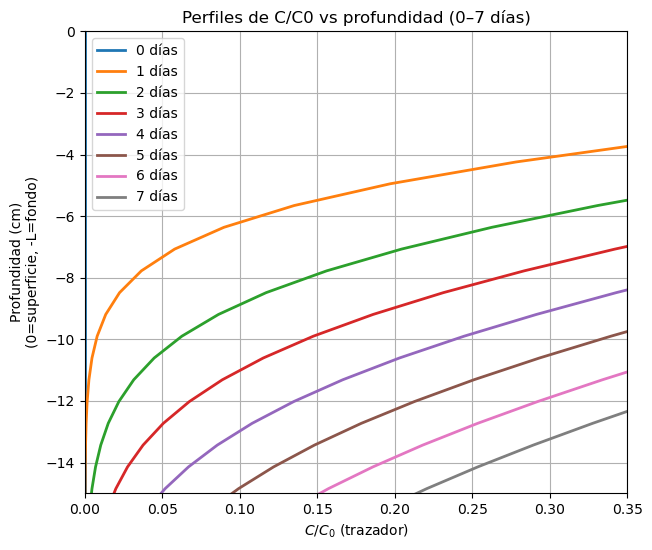

In [25]:
plt.figure(figsize=(7,6))

for d, idx in zip(dias_obj, idx_plot):
    C_profile = C_hist[idx] / C0
    C_profile = np.clip(C_profile, 0.0, 1.0)
    plt.plot(C_profile, depth, lw=2, label=f"{int(d)} días")

plt.xlabel(r"$C/C_0$ (trazador)")
plt.ylabel("Profundidad (cm)\n(0=superficie, -L=fondo)")
plt.title("Perfiles de C/C0 vs profundidad (0–7 días)")
plt.grid(True)

# --- Mejoras visuales ---
plt.ylim(-15, 0)            # zoom en los primeros 15 cm
plt.xlim(0.0, 0.35)         # ajuste a valores que realmente aparecen
plt.legend()
plt.show()


#### 5.2 Gráfica de la cantidad volumetrica de agua en los suelos

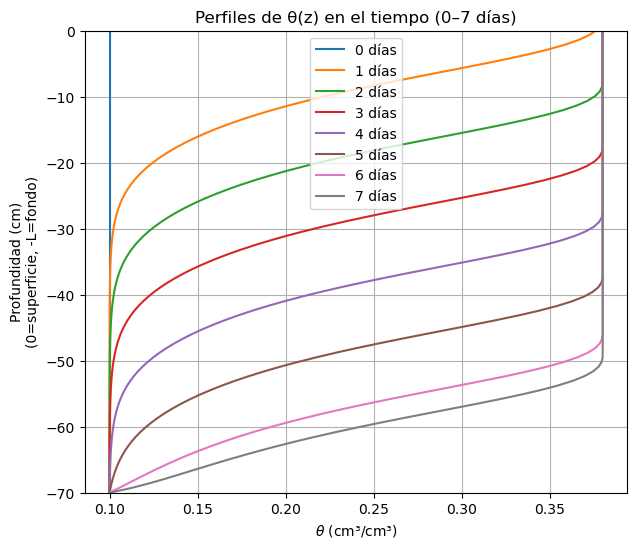

In [26]:

plt.figure(figsize=(7,6))
for d, idx in zip(dias_obj, idx_plot):
    th_profile = theta_hist[idx]
    plt.plot(th_profile, depth, label=f"{int(d)} días")

plt.xlabel(r"$\theta$ (cm³/cm³)")
plt.ylabel("Profundidad (cm)\n(0=superficie, -L=fondo)")
plt.legend()
plt.grid(True)
plt.title("Perfiles de θ(z) en el tiempo (0–7 días)")
plt.ylim(-L, 0)
plt.show()
